# EDA
Exploratory analysis of `all_queries.csv`.

**Primary goals**
- Verify schema, completeness, and data quality.
- Understand feature distributions and relationships.
- Determine preprocessing steps before modeling.


## EDA takeaways → feature candidates and pipeline actions

**Feature candidates (not proven importance)**
- Target: `price_value`.
- Strong numeric/specs: `screen_size_in`, `resolution_width`, `resolution_height`, `refresh_rate_hz`, `response_time_ms`.
- Derived: `resolution_pixels = resolution_width * resolution_height`, `aspect_ratio` (if missing), `price_log = log1p(price_value)` for modeling.
- Categorical: `brand`, `panel_type`, `condition` / `condition_id`, `hdr`, `has_adaptive_sync`.

**Low-signal or ID-like (exclude from model features)**
- `item_id`, `legacy_item_id`, `item_url` (identifiers).
- `title` only if you plan NLP/keyword extraction.

**High-missingness columns (avoid unless you impute heavily)**
- `depth_in` (100% missing), `ports` (~79%), `brightness_nits` (~64%), `width_in` / `height_in` / delivery dates (~56–59%).

**Implications for pipeline**
- Ingestion: enforce numeric types; validate currency; log missingness stats.
- Transformation: drop ID-like columns; impute numeric with median; fill categoricals with `Unknown`; encode categoricals; add derived features.


In [11]:
from pathlib import Path

def find_repo_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(6):
        if (cur / "README.md").exists() and (cur / "notebook").exists():
            return cur
        cur = cur.parent
    return start.resolve()

ROOT = find_repo_root(Path.cwd())
csv_path = ROOT / "notebook" / "data" / "ebay" / "all_queries.csv"

if not csv_path.exists():
    raise FileNotFoundError(f"Missing file: {csv_path}. Run: python src/components/combine_all_queries.py")

df = pd.read_csv(csv_path)
df.head()


,query_slug,item_id,legacy_item_id,item_url,title,price_value,price_currency,condition,condition_id,seller_username,...,panel_type,aspect_ratio,response_time_ms,brightness_nits,hdr,has_adaptive_sync,ports,width_in,height_in,depth_in
0,budget_monitor,v1|236102085204|536637454833,236102085204,https://www.ebay.com/itm/236102085204?_skw=bud...,"DELL 23"" LCD LED Widescreen Budget display com...",54.99,USD,Used,3000,pc_choice,...,LCD,16:9,8.0,NaN,NaN,NaN,1080x HDMI,NaN,NaN,NaN
1,budget_monitor,v1|326947661180|0,326947661180,https://www.ebay.com/itm/326947661180?_skw=bud...,Budget Gaming PC Setup – i9-9900K | RTX 3060 1...,650.00,USD,Used,3000,reevesjpa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,budget_monitor,v1|267381319558|0,267381319558,https://www.ebay.com/itm/267381319558?_skw=bud...,"Pixio PX246 Wave White 24"" 1080p 120Hz Budget ...",84.99,USD,Used,3000,pixiogaming,...,IPS,16:9,4.0,NaN,NaN,True,NaN,7.2,16.86,NaN
3,budget_monitor,v1|236099877568|536635335801,236099877568,https://www.ebay.com/itm/236099877568?_skw=bud...,"DELL 22"" LCD LED Widescreen Budget display com...",49.99,USD,Used,3000,pc_choice,...,LCD,16:9,8.0,NaN,NaN,NaN,1080x HDMI,NaN,NaN,NaN
4,budget_monitor,v1|267498860280|0,267498860280,https://www.ebay.com/itm/267498860280?_skw=bud...,"Pixio PX246 Wave White 24"" 1080p 120Hz Budget ...",84.99,USD,Used,3000,pixiogaming,...,IPS,16:9,4.0,NaN,NaN,True,NaN,7.2,16.86,NaN


## Dataset structure
- Goal: confirm row/column counts, data types, and non-null counts.
- What to look for: unexpected dtypes (e.g., numeric stored as text), sparse columns, or columns that should be dropped.
- What to do next: fix dtypes, decide if any columns are too sparse to keep.


In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   query_slug             95 non-null     object 
 1   item_id                95 non-null     object 
 2   legacy_item_id         95 non-null     int64  
 3   item_url               95 non-null     object 
 4   title                  95 non-null     object 
 5   price_value            95 non-null     float64
 6   price_currency         95 non-null     object 
 7   condition              95 non-null     object 
 8   condition_id           95 non-null     int64  
 9   seller_username        95 non-null     object 
 10  seller_feedback_pct    95 non-null     float64
 11  seller_feedback_score  95 non-null     float64
 12  buying_options         95 non-null     object 
 13  shipping_cost          86 non-null     float64
 14  shipping_currency      86 non-null     object 
 15  shipping

## Summary statistics
- Goal: quick numeric and categorical sanity check (ranges, outliers, cardinality).
- What to look for: impossible values (negative prices), extreme outliers, and high-cardinality categoricals.
- What to do next: cap/clip obvious errors, plan encoding strategy for categorical features.


In [13]:
df.describe(include='all').transpose()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
query_slug,95,2,gaming_monitor,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_id,95,95,v1|236102085204|536637454833,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
legacy_item_id,95.0,NaN,NaN,NaN,260672483274.494751,72910790922.569275,116777008916.0,236102079650.5,267228781392.0,306097466609.0,389511015261.0
item_url,95,95,https://www.ebay.com/itm/236102085204?_skw=bud...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,95,95,"DELL 23"" LCD LED Widescreen Budget display com...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price_value,95.0,NaN,NaN,NaN,163.907474,138.411689,20.0,83.69,129.6,181.99,650.99
price_currency,95,1,USD,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,95,6,Certified - Refurbished,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition_id,95.0,NaN,NaN,NaN,1927.473684,601.439706,1000.0,1500.0,2000.0,2000.0,3000.0
seller_username,95,26,acer,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Missingness profile
- Goal: quantify missing values by column to prioritize cleaning.
- What to look for: columns with high missingness (e.g., >40–60%), which may be unreliable.
- What to do next: drop very sparse columns, or impute with domain-appropriate strategies.


In [14]:
missing = df.isna().mean().sort_values(ascending=False)
missing


depth_in                 1.000000
ports                    0.736842
brightness_nits          0.694737
width_in                 0.673684
height_in                0.663158
hdr                      0.557895
has_adaptive_sync        0.378947
max_delivery_date        0.315789
min_delivery_date        0.315789
aspect_ratio             0.200000
shipping_cost            0.094737
shipping_currency        0.094737
shipping_cost_type       0.073684
response_time_ms         0.073684
resolution_width         0.021053
resolution_height        0.021053
panel_type               0.010526
color                    0.010526
query_slug               0.000000
legacy_item_id           0.000000
item_id                  0.000000
buying_options           0.000000
seller_feedback_score    0.000000
brand                    0.000000
condition_id             0.000000
seller_username          0.000000
seller_feedback_pct      0.000000
title                    0.000000
price_value              0.000000
item_url      

## Numeric histograms
- Purpose: visualize each numeric feature’s distribution to spot skew, heavy tails, or multimodality.
- What to look for: long right tails (log transform candidates), spikes at 0, or weird gaps.
- What to do next: apply transforms (log/box-cox), cap outliers, or create bins.


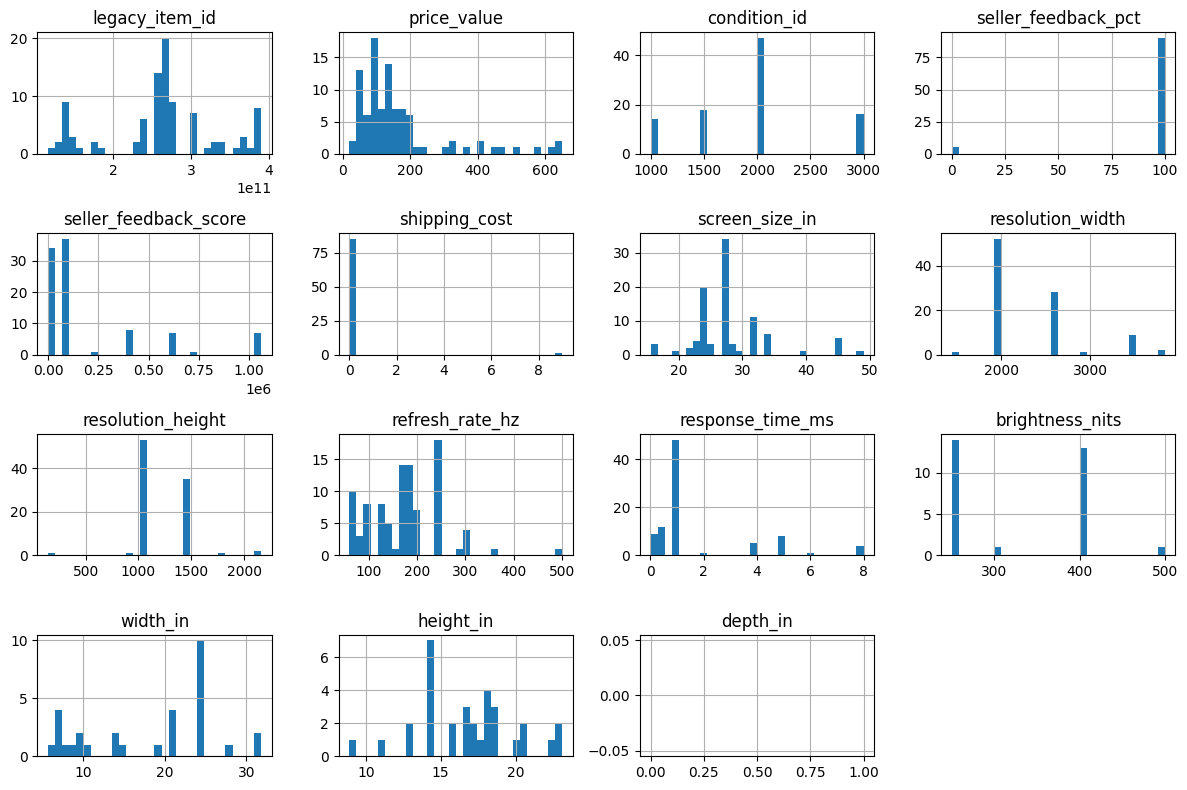

In [15]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].hist(bins=30, figsize=(12, 8))
plt.tight_layout()


## Correlation heatmap (numeric)
- Purpose: identify linear relationships and multicollinearity among numeric features.
- What to look for: strong correlations (|r| > 0.7) that indicate redundancy.
- What to do next: drop or combine highly correlated features, or use regularization.


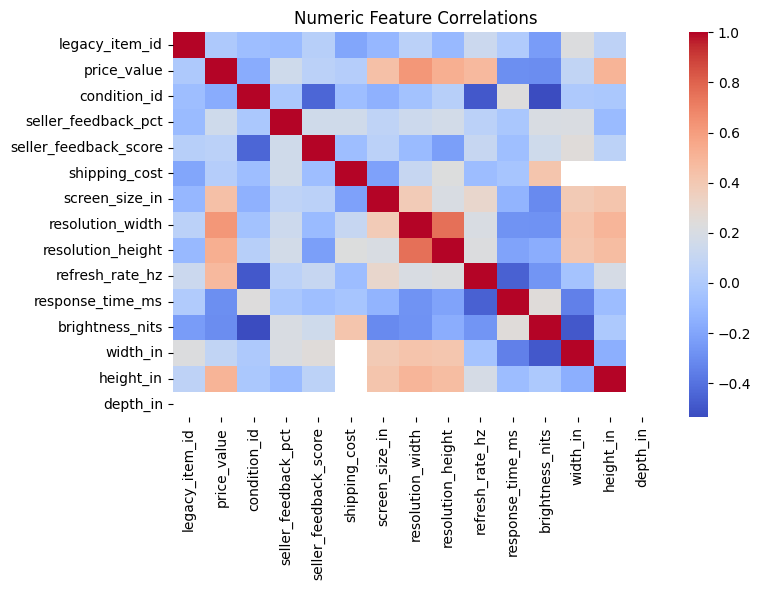

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=False, cmap='coolwarm')
plt.title('Numeric Feature Correlations')
plt.tight_layout()


## Price distribution
- Purpose: understand the target/price spread, skew, and presence of outliers.
- What to look for: strong right-skew, price spikes, or multiple price bands.
- What to do next: consider log-transforming price, trimming extreme outliers, and segmenting by product category if bands appear.


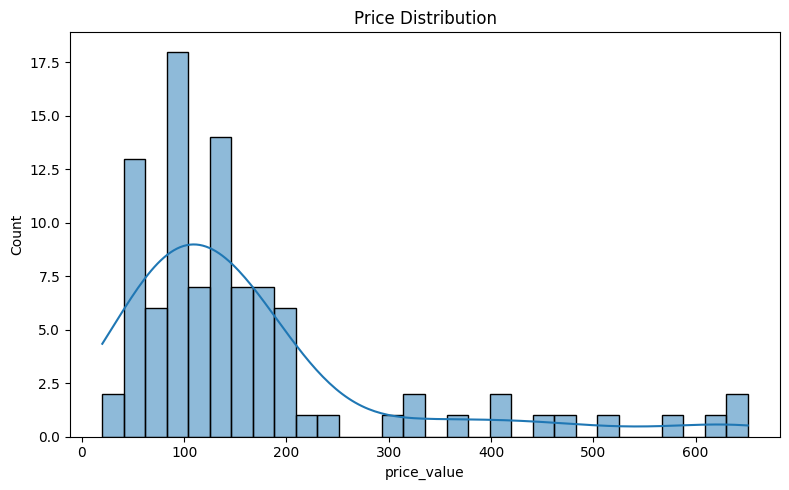

In [17]:
if 'price_value' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(df['price_value'], bins=30, kde=True)
    plt.title('Price Distribution')
    plt.tight_layout()


## Categorical features
- Goal: identify candidate categorical columns for encoding.
- What to look for: very high cardinality (e.g., thousands of unique values) that may require hashing or target encoding.
- What to do next: decide encoding strategy and consider grouping rare categories.


In [18]:
cat_cols = [c for c in df.columns if df[c].dtype == 'object']
cat_cols[:10]


['query_slug',
 'item_id',
 'item_url',
 'title',
 'price_currency',
 'condition',
 'seller_username',
 'buying_options',
 'shipping_currency',
 'shipping_cost_type']